# Dynamic Environment Tests
Gridworld where a shortcut opens up halfway through. 

With agents that learn __and__ plan


* Position in the gridworld is the state
* Actions are compass moves between positions.
* Reward is 0 everywhere, except when reaching the goal, where it is 1

# Environment

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Maze:
    '''Class defining the environment'''
    def __init__(self, shapex, shapey, walls, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.walls  = walls
        self.start  = start
        self.goal   = goal
        self.idx    = self.build_index()
        self.size   = shapex * shapey
        
        self.set_bitmap()
        self.original_walls = walls.copy()
        
    def reset_walls(self):
        '''In a dynamic environment reset the walls to the original state'''
        self.walls  = self.original_walls
        self.set_bitmap()
        
    def state_from_index(self, number):
        '''get state from index'''
        x = number // self.shapey
        y = number  % self.shapey
        
        return (x, y)
        
    def build_index(self):
        '''build index for indexing states'''
        return {(x, y) : self.shapey * x + y for x in range(self.shapex) 
                for y in range(self.shapey)}
        
    def set_bitmap(self):
        '''builds the bitmap for visualisation'''
        bitmap = np.ones((self.shapex, self.shapey))
        
        for wall in self.walls:
            bitmap[wall] = 0
        
        self.bitmap = bitmap
    
    def show_bitmap(self):
        '''shows the environment of holes and walkable path'''
        plt.imshow(self.bitmap)
        
    def change(self, add=[], remove=[]):
        '''add or remove walls'''
        self.walls.extend([i for i in add])
        self.walls = [wall for wall in self.walls if wall not in remove]
        self.set_bitmap()

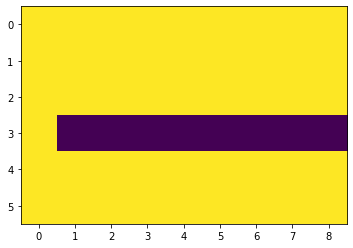

In [3]:
shapex = 6
shapey = 9
start  = (5, 5)
goal   = (0, 8)
walls  = [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8)]

shortcut = Maze(shapex, shapey, walls, start, goal)
shortcut.show_bitmap()

# Implementations
### Dyna-Q

In [4]:
class DynaQ:
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95):
        self.maze       = maze
        self.moves      = moves
        self.plan_steps = plan_steps
        self.alpha      = alpha
        self.epsilon    = epsilon
        self.gamma      = gamma
        self.move_idx   = {moves[i] : i for i in range(len(moves))}
    
    # -------------------------------------------Methods-------------------------------------------------#
    
    def reset(self):
        '''Called once in the beginning to initialize variables'''
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.history = [set()] * self.maze.size # History for planning part
        self.history_full = np.zeros(self.maze.size, dtype=bool)
        
            
    def step(self, S, A):
        '''Move and record to history'''
        Sn, R = self.move(S, A)

        # Only add to History if it isnt full yet
        if not self.history_full[self.maze.idx[S]]:
            self.history[self.maze.idx[S]].add(A)
            if len(self.history[self.maze.idx[S]]) == 4:
                self.history_full[self.maze.idx[S]] = 1
                
        self.visited = [i for i, h in enumerate(self.history) if h]
        return Sn, R
        
    def q_update(self, S, A, R, Sn):
        '''Update State-Action-Values'''
        Am       = np.argmax(self.Q[Sn])
        idx      = (S[0],  S[1],  A)
        idxn     = (Sn[0], Sn[1], Am)
        self.Q[idx] += self.alpha * (R + self.gamma * self.Q[idxn] - self.Q[idx])
        
    def m_update(self, S, A, R, Sn):
        '''Update Model'''
        idx         = (S[0], S[1], A)
        self.M[idx] = R, Sn[0], Sn[1]
        
    def update(self, S, A, R, Sn):
        '''To easily call from training function'''
        self.q_update(S, A, R, Sn)
        self.m_update(S, A, R, Sn)
        
    def plan(self):
        '''Planning section'''
        for step in range(self.plan_steps):
            Spi = random.choice(self.visited)
            Sp  = self.maze.state_from_index(Spi)
            Ap  = random.choice(tuple(self.history[Spi]))
            Rp  = self.M[Sp[0], Sp[1], Ap, 0]
            Spn = tuple(self.M[Sp[0], Sp[1], Ap, 1:])
            
            self.q_update(Sp, Ap, Rp, Spn)
            
    def done(self, S):
        '''Have we reached the goal?'''
        return S == self.maze.goal
    
    # --------------------------------------------Setup--------------------------------------------------#
    
    def move(self, S, A):
        '''Move from state S with action A giving new state Sn and reward R'''
        # Clamp values to map
        direction = self.moves[A]
        
        Sx  = int(max(0, min(self.maze.shapex - 1, S[0] + direction[0])))
        Sy  = int(max(0, min(self.maze.shapey - 1, S[1] + direction[1])))
        Sn = (Sx, Sy)

        # Reset position if falling in hole
        if Sn in self.maze.walls:
            Sn = S

        R = 1 if Sn == self.maze.goal else 0

        return Sn, R
    
    def greedy(self, S):
        '''Greedy policy'''
        return np.argmax(self.Q[S])
    
    def epsilon_greedy(self, S):
        '''Epsilon greedy policy'''
        return np.argmax(self.Q[S]) if np.random.rand() > self.epsilon else np.random.randint(len(moves))
    
    def trace(self):
        '''Path following greedy policy'''
        S = self.maze.start
        path = []

        while not self.done(S):
            path.append(S)
            A    = self.greedy(S)
            S, _ = self.step(S, A)

            # Loop detection
            if S in path:
                print("State Values dont create greedy path")
                break

        return path
    
    # -------------------------------------------Imaging-------------------------------------------------#
    
    def create_best_path_img(self):
        '''Create grid in which best path is highlighted'''
        path = self.trace()
        
        c0 = 5
        c1 = 6
        
        length    = len(path)
        grid      = self.maze.bitmap.copy()
        fade      = np.linspace(c0, c1, num=length)
        
        for i in range(length):
            grid[path[i]] = fade[i]
            
        grid[self.maze.start] = c0
        grid[self.maze.goal]  = c1
        
        print(f"path length: {length}")
        return grid
    
    def create_direction_map_img(self):
        '''Create grid with best path and best action for every state'''
        arr_len    = 0.85
        grid       = self.create_best_path_img()
        directions = [(S, self.greedy(S))
                      for x in range(self.maze.shapex) 
                      for y in range(self.maze.shapey) if (S := (x, y))]   

        for i in directions:
            if i[0] not in self.maze.walls and i[0] != self.maze.goal:
                    dx = arr_len if i[1] == 2 else -arr_len if i[1] == 1 else 0 
                    dy = arr_len if i[1] == 3 else -arr_len if i[1] == 0 else 0
                    plt.arrow(i[0][1], i[0][0], dx, dy, head_width=0.1)

        return grid
    
    def draw_path_and_dir_map(self):
        '''Plot best path and best action for every graph'''
        plt.imshow(self.create_direction_map_img())

### DynaQ+
Additional variable $\tau$ tracking for each state how many timesteps have gone by since it was last visited.

In the planning phase we add $k \cdot \sqrt{\tau}$ to the planned reward. This changes the estimated values for states and actions but _encourages_ exploration.

In [5]:
class DynaQPlus(DynaQ):
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=0.00001):
        super().__init__(maze, moves, plan_steps, alpha, epsilon, gamma)
        self.k = k
        
    def reset(self):
        '''Called once in the beginning to initialize variables'''
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.T = np.zeros(self.maze.size)
        self.history      = [set()] * self.maze.size # History for planning part
        self.history_full = np.zeros(self.maze.size)
            
    def step(self, S, A):
        '''Move and record to history
        Also update time of last visit to states'''
        Sn, R = self.move(S, A)
        self.T[self.maze.idx[S]] = 0

        # Only add to History if it isnt full yet
        if not self.history_full[self.maze.idx[S]]:
            self.history[self.maze.idx[S]].add(A)
            if len(self.history[self.maze.idx[S]]) == 4:
                self.history_full[self.maze.idx[S]] = 1
                
        self.visited = [i for i, h in enumerate(self.history) if h]
        
        for i in self.visited:
            self.T[i] += 1
            
        return Sn, R
                
    def plan(self):
        '''Planning part including bonus reward for older states'''
        for step in range(self.plan_steps):
            Spi = random.choice(self.visited)
            Sp  = self.maze.state_from_index(Spi)
            Ap  = random.choice(tuple(self.history[Spi]))
            Rp  = self.M[Sp[0], Sp[1], Ap, 0] + self.k * np.sqrt(self.T[Spi])
            Spn = tuple(self.M[Sp[0], Sp[1], Ap, 1:])
            
            self.q_update(Sp, Ap, Rp, Spn)

### DynaQ+Experiment (Ex. 8.4)
Instead of adding $k \cdot \sqrt{\tau}$ to the planned reward, we change our greedy action to be greedy towards the reward $R + k \cdot \sqrt{\tau}$.

In [ ]:
class DynaQPlusExperiment(DynaQ):
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=0.00001):
        super().__init__(maze, moves, plan_steps, alpha, epsilon, gamma)
        self.k = k
        
    def reset(self):
        '''Called once in the beginning to initialize variables'''
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.T = np.zeros(self.maze.size)
        self.history      = [set()] * self.maze.size # History for planning part
        self.history_full = np.zeros(self.maze.size)
            
    def step(self, S, A):
        '''Move and record to history
        Also update time of last visit to states'''
        Sn, R = self.move(S, A)
        self.T[self.maze.idx[S]] = 0

        # Only add to History if it isnt full yet
        if not self.history_full[self.maze.idx[S]]:
            self.history[self.maze.idx[S]].add(A)
            if len(self.history[self.maze.idx[S]]) == 4:
                self.history_full[self.maze.idx[S]] = 1
                
        self.visited = [i for i, h in enumerate(self.history) if h]
        
        for i in self.visited:
            self.T[i] += 1
        
        return Sn, R
    
    def epsilon_greedy(self, S):    
        '''Epsilon greedy policy including bonus to older states'''
        i = np.argmax([self.Q[Sn][i] + self.k * np.sqrt(self.T[self.maze.idx[Sn]]) 
                       for i in range(len(self.moves)) 
                       if (Sn := self.move(S, i)[0])])
        
        return i if np.random.rand() > self.epsilon else np.random.randint(len(moves))

### Prioritized Sweeping
In DynaQ we plan updates from a random sampling of states, in Prioritized Sweeping we have a queue which prioritizes updates by size of the update. Parameter $\theta$ determines the minimum size of an update.

The updates then start at the biggest change and work their way to the smallest change. 

In [62]:
class PrioritizedSweep(DynaQ):
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, theta=0.1):
        super().__init__(maze, moves, plan_steps, alpha, epsilon, gamma)
        self.theta = theta
    
    def reset(self):
        '''Called once in the beginning to initialize variables'''
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.PQueue = []
        
    def p_update(self, S, A, R, Sn):
        '''Insert state-action pair into queue if P is big enough'''
        Am       = np.argmax(self.Q[Sn])
        idx      = (S[0],  S[1],  A)
        idxn     = (Sn[0], Sn[1], Am)
        P        = abs(R + self.gamma * self.Q[idxn] - self.Q[idx])
        if P > self.theta:
            self.try_to_insert(P, S, A)
            
    def step(self, S, A):
        '''Move to next state'''
        Sn, R = self.move(S, A)
        return Sn, R
    
    def update(self, S, A, R, Sn):
        '''Update function to be used in the train function'''
        self.m_update(S, A, R, Sn)
        self.p_update(S, A, R, Sn)
        
    def plan(self):
        '''Rather complex planning part.
        Working through the queue, 
        updating state-action values,
        adding more state-action pairs to the queue'''
        for step in range(self.plan_steps):
            if len(self.PQueue) > 0:
                _, S, A = self.PQueue.pop(0)
                idx     = (S[0],  S[1],  A)
                R       = self.M[idx][0]
                Sn      = tuple(self.M[idx][1:])
                self.q_update(S, A, R, Sn)
                
                # Catch all states leading to S according to Model M
                MP = []
                for x in range(self.maze.shapex):
                    for y in range(self.maze.shapey):
                        for a in range(len(self.moves)):
                            if S == tuple(self.M[x, y, a][1:]):
                                D = self.M[x, y, a]
                                MP.append((D[0], D[1], D[2], a))
                
                for i in range(len(MP)):
                    Rp, Spx, Spy, Ap = MP[i]
                    self.p_update((Spx, Spy), Ap, Rp, S)
    
    def try_to_insert(self, P, S, A):
        '''Find out if S, A already exists in queue
        Only insert if new P value is bigger'''
        to_insert = (P, S, A)
        found     = False
        idx       = 0
        
        for idx in range(len(self.PQueue)):
            if self.PQueue[idx][1] == S and self.PQueue[idx][2] == A:
                found = True
                if P > self.PQueue[idx][0]:
                    insert_idx = self.insert_into_queue(to_insert, idx + 1)
                    self.remove_lower_values(insert_idx, S, A)
                    break
                    
        if not found:
            self.PQueue.append(to_insert)
            
    def insert_into_queue(self, tup, max_idx):
        '''Insert P, S, A tuple into queue, its maximum index can be max_idx'''
        for idx in range(max_idx):
            if tup[0] > self.PQueue[idx][0]:
                self.PQueue.insert(idx, tup)
                break
            
        return idx
    
    def remove_lower_values(self, idx, S, A):
        '''Removes lower values of same state-action.
        Can break after finding one because 
        we only keep one of it in the queue'''
        while idx < len(self.PQueue):
            if self.PQueue[idx][1] == S and self.PQueue[idx][2] == A:
                del self.PQueue[idx]
                break
            idx += 1

# Testing
Shortcut world, shortcut opens when we're halfway through the learning process.
If the agent doesn't reach the goal after 50 episodes I cut it off without reward. 

In [8]:
episodes = 6000
moves    = [(-1, 0), (0, -1), (0, 1), (1, 0)]
world    = shortcut
switch   = 3000
remove   = [(3, 8)]

In [61]:
def train(agent, world, switch=-1, add=[], remove=[]):
    agent.reset()    
    world.reset_walls()
    reward_history = []

    for episode in range(episodes):
        S = world.start
        t = 0

        if episode == switch:
            world.change(add=add, remove=remove)

        while True:
            A     = agent.epsilon_greedy(S)
            Sn, R = agent.step(S, A)
            agent.update(S, A, R, Sn)

            S = Sn
            agent.plan()
            
            t += 1
            if agent.done(S) or t > 50:
                reward_history.append((R, t))
                break

    return np.array(reward_history)

### DynaQ Run

path length: 18


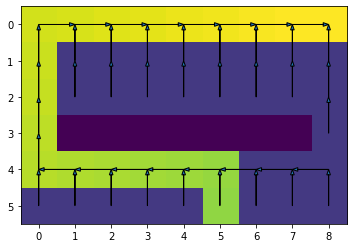

In [10]:
agent   = DynaQ(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95)
reward1 = train(agent, world, switch=switch, remove=remove)
agent.draw_path_and_dir_map();

### DynaQ+ Run

path length: 8


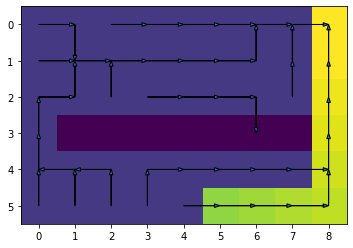

In [11]:
agent2  = DynaQPlus(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=10e-3)
reward2 = train(agent2, world, switch=switch, remove=remove)
agent2.draw_path_and_dir_map();

### DynaQ+Experiment Run
(takes a while)

path length: 8


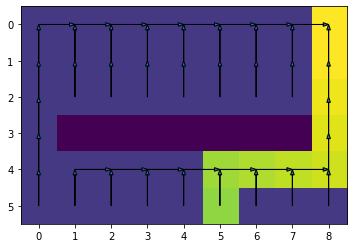

In [12]:
agent3  = DynaQPlusExperiment(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=0.001)
reward3 = train(agent3, world, switch=switch, remove=remove)
agent3.draw_path_and_dir_map();

### Priorized Sweeping Run
The prioritization of updates leads less timesteps to converge to the optimal path. 
But we run 6k episodes just like all of the other methods, so we only see the speedup in the graph later on.

In [ ]:
agent4  = PrioritizedSweep(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, theta=0.0001)
reward4 = train(agent4, world, switch=switch, remove=remove)
agent4.draw_path_and_dir_map();

# Results
DynaQ doesn't find the newly opened shortcut, while DynaQ+ and DynaQ+E both do. 

## Cumulative Rewards

In [ ]:
def cumsum(reward):
    '''calculate weighted cumulative rewards given by training function'''
    return np.cumsum([i[0] / i[1] for i in reward])

def plot(episodes, rewards, labels, switch):
    '''plot cumulative rewards for different agents'''
    x       = np.arange(episodes)
    cumsums = [cumsum(reward) for reward in rewards]
    largest_reward = max([cs[-1] for cs in cumsums])
    
    for i in range(len(cumsums)):
        plt.plot(x, cumsums[i], label=labels[i])
    plt.vlines(switch, 0, largest_reward, linestyles='dashed', label='Shortcut open')
    plt.xlabel('Episode No.')
    plt.ylabel('Average Cumulative Reward')
    plt.title('Comparison of Cumulative Rewards over time')
    plt.legend()
    plt.show()

In [ ]:
plot(episodes, 
     [reward1, reward2, reward3, reward4], 
     ['DynaQ', 'DynaQ+', 'DynaQ+E', 'PrioSweep'], 
     switch)

# Testing 2
Old path closes up at 1000 episodes, new one opens up on other side for 2000 more episodes

In [ ]:
episodes = 3000
moves    = [(-1, 0), (0, -1), (0, 1), (1, 0)]
world    = shortcut
switch   = 1000
add      = [(3, 0)]
remove   = [(3, 8)]

### DynaQ

In [ ]:
reward1 = train(agent1, world, switch=switch, add=add, remove=remove)
agent1.draw_path_and_dir_map();

### DynaQ+

In [ ]:
reward2 = train(agent2, world, switch=switch, add=add, remove=remove)
agent2.draw_path_and_dir_map();

### DynaQ+Experiment

In [ ]:
reward3 = train(agent3, world, switch=switch, add=add, remove=remove)
agent3.draw_path_and_dir_map();

### Prioritized Sweep

In [ ]:
reward4 = train(agent4, world, switch=switch, add=add, remove=remove)
agent4.draw_path_and_dir_map();

## Plot

In [ ]:
plot(episodes, 
     [reward1, reward2, reward3, reward4], 
     ['DynaQ', 'DynaQ+', 'DynaQ+E', 'PrioSweep'], 
     switch)